# Vector Autoregressive Models (VAR)

<font color=red>Note: not to confuse with Value-at-Risk (**VaR**) modelling.</font>


Vector Autoregression (VAR) is a multivariate forecasting algorithm that is used when two or more time series influence each other. That means, the basic requirements in order to use VAR are:
- You need at least two time series (variables)
- The time series should influence each other.
  
Why is it called Autoregressive?  
- It is considered as an Autoregressive model because, each variable (Time Series) is modeled as a function of the past values, that is the predictors are nothing but the lags (time delayed value) of the series.

How is VAR different from other Autoregressive models like AR and ARMA?
- The primary difference is those models are uni-directional, where, the predictors influence the Y and not vice-versa. Whereas, Vector Auto Regression (VAR) is bi-directional. That is, the variables influence each other. 

If you remember in Autoregression models, the time series is modeled as a linear combination of it's own lags. That is, the past values of the series are used to forecast the current and future. A typical $AR(p)$ model equation looks something like this:  

$Y_t=\beta_0+\beta_1Y_{t-1}+\beta_2Y_{t-2}+\dots+\beta_pY_{t-p}+\epsilon_t$  

Order $p$ means, up to $p$-lags of $Y$ are used and they are the predictors in the equation. The $\epsilon_t$ is the error, which is considered to be white noise.  

In the VAR model, each variable is modeled as a linear combination of past values of itself and the past values of other variables in the system. Since you have multiple time series that influence each other, it is modeled as a system of equations with one equation per variable (time series). That is, if you have 5 time series that influence each other, we will have a system of 5 equations.  

Suppose you have two variables (Time series) $Y_1$ and $Y_2$, and you need to forecast the values of these variables at time $t$. To calculate $Y_{1,t}$, VAR will use the past values of both $Y_1$ as well as $Y_2$. Likewise, to compute $Y_{2,t}$, the past values of both $Y_1$ and $Y_2$ be used. For example, the system of equations for a VAR(2) model with two time series (variables $Y_1$ and $Y_2$) is as follows:

$Y_{1,t}=\beta_{1,0}+\beta_{11,1}Y_{1,t-1}+\beta_{12,1}Y_{2,t-1}+\beta_{11,2}Y_{1,t-2}+\beta_{12,2}Y_{2,t-2}+\epsilon_{1,t}$  
$Y_{2,t}=\beta_{2,0}+\beta_{21,1}Y_{1,t-1}+\beta_{22,1}Y_{2,t-1}+\beta_{21,2}Y_{1,t-2}+\beta_{22,2}Y_{2,t-2}+\epsilon_{2,t}$  

where, $Y_{1,t-1}$ and $Y_{2,t-1}$ are the first lag of time series $Y_1$ and $Y_2$ respectively, and slope coefficients' subscript notation $\beta_{nk,p}$ : $n$ equation number, $k$ variable number, $p$ lag number.  

The above equation is referred to as a VAR(2) model, because, each equation is of order 1, that is, it contains up to one lag of each of the predictors. Since the $Y$ terms in the equations are interrelated, the $Y$s are considered as endogenous variables, rather than as exogenous predictors.

Likewise, the third order VAR(3) model for two variables would include up to three lags for each variable 

## Building a VAR model in Python

The procedure to build a VAR model involves the following steps:

1. Analyze the time series characteristics
 - Test for causation amongst the time series
 - Test for stationarity
 - Transform the series to make it stationary, if needed
 - Find optimal order (p)
2. Prepare training and test datasets
3. Fit ("train") the model
4. Roll back the transformations, if any.
5. Evaluate the model using test set
6. Forecast to future



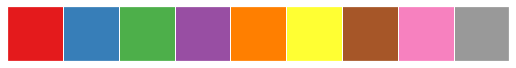

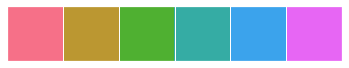

In [1]:
import numpy as np

import pandas as pd
#pd.set_option('display.max_columns', 30)                    # Display 30 columns for viewing purposes
#pd.options.display.float_format = '{:,.2f}'.format         # Reduce decimal points to 2

import datetime as dt
#import pandas_datareader.data as web

import statsmodels
# we will use `smf` and `sm` to constract and estimate same regressions but using different ways
import statsmodels.formula.api as smf  
import statsmodels.api as sm
import statsmodels.stats.api as sms
from patsy import dmatrices
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.stattools import acf

from statsmodels.tools.eval_measures import rmse, aic
#from sklearn.metrics import mean_squared_error

from linearmodels import PanelOLS, RandomEffects
from linearmodels import IV2SLS, IVLIML, IVGMM, IVGMMCUE
from linearmodels.iv.results import compare


from collections import OrderedDict


from matplotlib import pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
sns.set_style('darkgrid')
sns.palplot(sns.color_palette("Set1"))
sns.palplot(sns.color_palette("husl"))
plt.rc("figure", figsize=(20, 20))
plt.rc("savefig", dpi=90)
plt.rc("font",family="sans-serif")
plt.rc("font",size=14)

## Import the dataset

The time series used is from Yash P Mehra’s 1994 article: “Wage Growth and the Inflation Process: An Empirical Approach”.

This dataset has the following 8 quarterly time series:

1. rgnp  : Real GNP.
2. pgnp  : Potential real GNP.
3. ulc   : Unit labor cost.
4. gdfco : Fixed weight deflator for personal consumption expenditure excluding food and energy.
5. gdf   : Fixed weight GNP deflator.
6. gdfim : Fixed weight import deflator.
7. gdfcf : Fixed weight deflator for food in personal consumption expenditure.
8. gdfce : Fixed weight deflator for energy in personal consumption expenditure.

In [2]:
df=pd.read_csv('data/Mehra1994.csv',parse_dates=['date'], index_col='date')
df

,rgnp,pgnp,ulc,gdfco,gdf,gdfim,gdfcf,gdfce
date,,,,,,,,
1959-01-01,1606.4,1608.3,47.5,36.9,37.4,26.9,32.3,23.1
1959-04-01,1637.0,1622.2,47.5,37.4,37.5,27.0,32.2,23.4
1959-07-01,1629.5,1636.2,48.7,37.6,37.6,27.1,32.4,23.4
1959-10-01,1643.4,1650.3,48.8,37.7,37.8,27.1,32.5,23.8
1960-01-01,1671.6,1664.6,49.1,37.8,37.8,27.2,32.4,23.8
...,...,...,...,...,...,...,...,...
1988-07-01,4042.7,3971.9,179.6,131.5,124.9,106.2,123.5,92.8
1988-10-01,4069.4,3995.8,181.3,133.3,126.2,107.3,124.9,92.9
1989-01-01,4106.8,4019.9,184.1,134.8,127.7,109.5,126.6,94.0


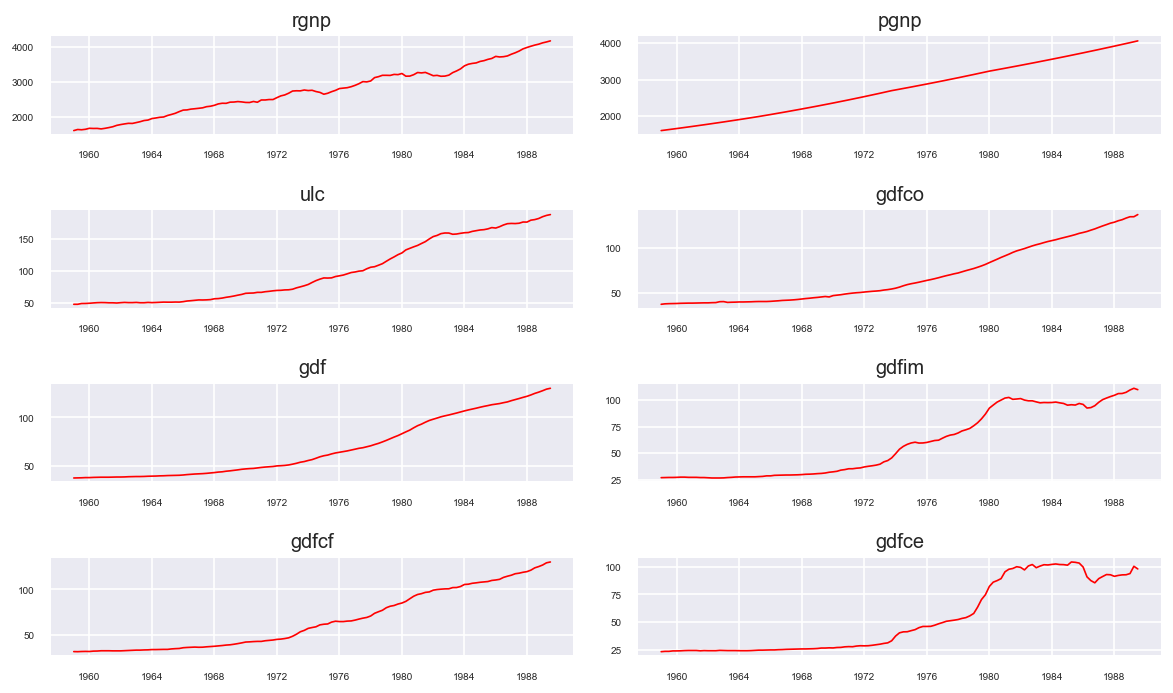

In [3]:
fig, axes = plt.subplots(nrows=4, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

Each of the series have a fairly similar trend patterns over the years except for gdfce and gdfim, where a different pattern is noticed starting in 1980.

## Testing Causation using Granger’s Causality Test

The basis behind Vector AutoRegression (VAR) is that each of the time series in the system influences each other. That is, you can predict the series with past values of itself along with other series in the system. Using **Granger's Causality Test**, it is possible to test this relationship before even building the model.  

**Granger's causality** tests the null hypothesis that the coefficients of past values in the regression equation is zero. In simpler terms, the past values of time series (X) do not cause the other series (Y). That is X does not  _Granger cause_ Y. So, if the $p$-value obtained from the test is lesser than the significance level (e.g., 0.05), then, you can safely reject the null hypothesis.  

The below code implements the Granger's Causality test for all possible combinations of the time series in a given dataframe and stores the p-values of each combination in the output matrix.

In [4]:
test = 'ssr_chi2test'

def grangers_causation_matrix(data, variables, maxlag=12, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the p-values. P-values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values are 
    zero, that is, X does not Granger cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

In [5]:
grangers_causation_matrix(df, variables = df.columns)

,rgnp_x,pgnp_x,ulc_x,gdfco_x,gdf_x,gdfim_x,gdfcf_x,gdfce_x
rgnp_y,1.0000,0.0003,0.0001,0.0212,0.0014,0.0620,0.0001,0.0071
pgnp_y,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
ulc_y,0.0000,0.0000,1.0000,0.0002,0.0000,0.0000,0.0000,0.0041
gdfco_y,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000
gdf_y,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000
gdfim_y,0.0011,0.0067,0.0014,0.0083,0.0011,1.0000,0.0004,0.0000
gdfcf_y,0.0000,0.0000,0.0008,0.0008,0.0000,0.0038,1.0000,0.0009
gdfce_y,0.0025,0.0485,0.0000,0.0002,0.0000,0.0000,0.0000,1.0000


The row are the Response ($Y$) and the columns are the predictor series ($X$). For example, if you take the value 0.0003 in (row 1, column 2), it refers to the $p$-value of $pgnp_x$ causing $rgnp_y$. Whereas, the 0.000 in (row 2, column 1) refers to the $p$-value of $rgnp_x$ causing $pgnp_y$.  

If a given $p$-value is less than significance level $\alpha$, then, the corresponding $X$ series (column) _granger_ causes the $Y$ (row). For example, $p$-value of 0.0003 at (row 1, column 2) represents the $p$-value of the Grangers Causality test for $pgnp_x$ causing $rgnp_y$, which is less that the conventional significance level of 0.05. Thus, you can reject the null hypothesis and conclude that $pgnp_x$ __Granger causes__ $rgnp_y$.  
Looking at the $p$-values in the above table, you can pretty much observe that all the variables (time series) in the system are interchangeably causing each other. This makes this system of multi time series a good candidate for using VAR models to forecast. 

## Cointegration Test

Cointegration test helps to establish the presence of a statistically significant connection between two or more time series.

What does **cointegration** mean? To understand that, you first need to know what is *order of integration* ($d$). Recall our discussion of unit root testing as well as $ARIMA(p,\textbf{d},q)$ models. Order of integration ($d$) is the number of differencing required to make a non-stationary time series stationary.  

Now, when you have two or more time series, and there exists a linear combination of them that has an order of integration ($d$) less than that of the individual series, then the collection of series is said to be cointegrated.  

When two or more time series are cointegrated, it means they have a long run, statistically significant relationship. This is the basic premise on which VAR models is based on. So, it is fairly common to implement the cointegration test before starting to build VAR models.

Johanssen (1991) devised a procedure to implement the cointegration test. 

`statsmodels.tsa.vector_ar.vecm.coint_johansen(endog, det_order, k_ar_diff)`
Parameters:
- `endog`: array_like (`nobs_tot` x `neqs`) Data to test
- `det_order` :
    - `-1` - no deterministic terms
    - `0` - constant term
    - `1` - linear trend
- `k_ar_diff`: nonnegative, Number of lagged differences in the model.



In [6]:
def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Significant?  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

In [7]:
cointegration_test(df)

Name   ::  Test Stat > C(95%)    =>   Significant?  
 ----------------------------------------
rgnp   ::  248.0     > 143.6691  =>   True
pgnp   ::  183.12    > 111.7797  =>   True
ulc    ::  130.01    > 83.9383   =>   True
gdfco  ::  85.28     > 60.0627   =>   True
gdf    ::  55.05     > 40.1749   =>   True
gdfim  ::  31.59     > 24.2761   =>   True
gdfcf  ::  14.06     > 12.3212   =>   True
gdfce  ::  0.45      > 4.1296    =>   False


## Split the Series into Training and Testing Data

The VAR model will be fitted on `df_train` and then used to forecast the next `nobs` observations. These forecasts will be compared against the actuals present in test data. To do the comparisons, we will use multiple forecast accuracy metrics.

In [8]:
nobs = 4
df_train, df_test = df[0:-nobs], df[-nobs:]

# Check size
print(df_train.shape)
print(df_test.shape)

(119, 8)
(4, 8)


## Check for Stationarity and Make the Time Series Stationary

Since the VAR model requires the time series you want to forecast to be stationary, it is customary to check all the time series in the system for stationarity. Just to refresh, a stationary time series is one whose characteristics like mean and variance does not change over time.

The popular ones are:
- Augmented Dickey-Fuller Test (ADF Test)
- KPSS test
- Philip-Perron test

If a series is found to be non-stationary, you make it stationary by differencing the series once and repeat the test again until it becomes stationary. Since, differencing reduces the length of the series by 1 and since all the time series has to be of the same length, you need to remove the leading cells in all the series in the system if you choose to difference at all.

In [9]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")    

In [10]:
# ADF Test on each column
for name, column in df_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "rgnp" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = 0.5428
 No. Lags Chosen       = 2
 Critical value 1%     = -3.488
 Critical value 5%     = -2.887
 Critical value 10%    = -2.58
 => P-Value = 0.9861. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "pgnp" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = 1.1556
 No. Lags Chosen       = 1
 Critical value 1%     = -3.488
 Critical value 5%     = -2.887
 Critical value 10%    = -2.58
 => P-Value = 0.9957. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "ulc" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. N

The ADF test confirms none of the time series is stationary. Let’s difference all of them once and check again.

In [11]:
# 1st difference
df_differenced = df_train.diff().dropna()

In [12]:
# Re-run ADF test on each differenced series.

# ADF Test on each column of 1st Differences Dataframe
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "rgnp" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.3448
 No. Lags Chosen       = 1
 Critical value 1%     = -3.488
 Critical value 5%     = -2.887
 Critical value 10%    = -2.58
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "pgnp" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.8282
 No. Lags Chosen       = 0
 Critical value 1%     = -3.488
 Critical value 5%     = -2.887
 Critical value 10%    = -2.58
 => P-Value = 0.3666. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "ulc" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Signifi

After the first difference, some of the variables are still not stationary. So, we are left with one of two choices. That is, 
- either proceed with 1st differenced series or 
- difference all the series one more time. 

In [13]:
# Second Differencing
df_differenced = df_differenced.diff().dropna()

# Re-run ADF test again on each second differenced series.

# ADF Test on each column of 2nd Differences Dataframe
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "rgnp" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -9.0123
 No. Lags Chosen       = 2
 Critical value 1%     = -3.489
 Critical value 5%     = -2.887
 Critical value 10%    = -2.58
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "pgnp" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -10.9813
 No. Lags Chosen       = 0
 Critical value 1%     = -3.488
 Critical value 5%     = -2.887
 Critical value 10%    = -2.58
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "ulc" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 T

All the series are now stationary. 

## How to Select the order $p$ of VAR($p$) model

To select the right order of the VAR model, we iteratively fit increasing orders of VAR model and pick the order that gives a model with least **AIC**. Though the usual practice is to look at the **AIC** or **BIC**, you can also check other best fit comparison estimates of **FPE** and **HQIC** (**Hannan-Quinn information criterion**).  

Setup VAR model
`statsmodels.tsa.vector_ar.var_model.VAR(endog, exog=None, dates=None, freq=None, missing='none')`  
Parameters:
- `endog` : array_like, 2-d endogenous response variable. 
- `exog` : array_like, 2-d exogenous variable.
- `dates` : array_like. must match number of rows of endog




Fit the VAR model
`VAR.fit(maxlags=None, method='ols', ic=None, trend='c', verbose=False)`
Parameters:
- `maxlags` : Maximum number of lags to check for order selection, defaults to 12 * (nobs/100.)**(1./4), see select_order function
- `method` : {‘ols’} Estimation method to use
- `ic` : {‘aic’, ‘fpe’, ‘hqic’, ‘bic’, None} Information criterion to use for VAR order selection. 
    - 'aic' : Akaike 
    - 'fpe' : Final prediction error 
    - 'hqic' : Hannan-Quinn 
    - 'bic' : Bayesian a.k.a. Schwarz
- `verbose` : bool, default False - Print order selection output to the screen
- `trend` : str {“c”, “ct”, “ctt”, “nc”, “n”} 
    - “c” - add constant 
    - “ct” - constant and trend 
    - “ctt” - constant, linear and quadratic trend 
    - “n”, “nc” - no constant, no trend. Note that these are prepended to the columns of the dataset.

In [14]:
# Trying to guess/return a string representing a frequency guess
df_differenced.index.inferred_freq

# more on this: https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases
# 'QS-OCT' = quarterly frequency, year ends in October

'QS-OCT'

In [15]:
model = VAR(df_differenced,freq=df_differenced.index.inferred_freq)
for i in [1,2,3,4,5,6,7,8,9]:
    result = model.fit(maxlags=i,method='ols',ic=None,trend='c',verbose=True)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  -1.3679402315450668
BIC :  0.34118471465888334
FPE :  0.2552682517347197
HQIC:  -0.6741331335699559 

Lag Order = 2
AIC :  -1.6212373944478258
BIC :  1.624943209529583
FPE :  0.20113494371371354
HQIC:  -0.3036288826795941 

Lag Order = 3
AIC :  -1.76580083870128
BIC :  3.0345473163767824
FPE :  0.18125103746164348
HQIC:  0.18239143783963208 

Lag Order = 4
AIC :  -2.000735164470316
BIC :  4.371215137654089
FPE :  0.15556966521481125
HQIC:  0.5849359332771087 

Lag Order = 5
AIC :  -1.9619535608363963
BIC :  5.999364562242095
FPE :  0.1869279438911487
HQIC:  1.268206331178332 

Lag Order = 6
AIC :  -2.330338652482907
BIC :  7.238452689088579
FPE :  0.16380374017443636
HQIC:  1.5514371669548055 

Lag Order = 7
AIC :  -2.5923313523471236
BIC :  8.6023872549378
FPE :  0.1823868583715424
HQIC:  1.9483069621146605 

Lag Order = 8
AIC :  -3.317261976458205
BIC :  9.52219581032303
FPE :  0.15573163248209088
HQIC:  1.8896071386220985 

Lag Order = 9
AIC :  -4.80476312595862

The selected order ($p$) is the order that gives the lowest AIC, BIC, FPE or HQIC scores. In the above output, the AIC drops to lowest at lag 4, then increases at lag 5 and then continuously drops further. FPE behaves similarly - lowest at order 4, until order 9 where it drops substantially. BIC and HQIC are more conservative and suggest order 1.  

Let's go with the lag 4 model.  

An alternate method to choose the order ($p$) of the VAR models is to use the `model.select_order(maxlags)` method.

In [16]:
x = model.select_order(maxlags=12, trend='c')
x.summary()

,AIC,BIC,FPE,HQIC
0,-0.07898,0.1232,0.9241,0.002961
1,-0.5721,1.248,0.5662,0.1653
2,-0.8256,2.612,0.4482,0.5674
3,-1.007,4.048,0.3937,1.042
4,-1.255,5.418,0.3399,1.449
5,-1.230,7.060,0.4147,2.129
6,-1.739,8.169,0.3286,2.276
7,-2.142,9.384,0.3340,2.528
8,-2.964,10.18,0.2744,2.362
9,-4.562,10.20,0.1413,1.420


<font color=red> Mystery: </font> why the observed AIC and BIC values differ when using `result.aic` versus as seen using `model.select_order()` is beyond me.

# Fit the VAR Model of Selected Order ($p=4$)

In [17]:
model_fitted = model.fit(4)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 13, Mar, 2022
Time:                     20:35:05
--------------------------------------------------------------------
No. of Equations:         8.00000    BIC:                    4.37122
Nobs:                     113.000    HQIC:                  0.584936
Log likelihood:          -905.679    FPE:                   0.155570
AIC:                     -2.00074    Det(Omega_mle):       0.0200322
--------------------------------------------------------------------
Results for equation rgnp
              coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------
const            2.430021         2.677505            0.908           0.364
L1.rgnp         -0.750066         0.159023           -4.717           0.000
L1.pgnp         -0.095621         4.938865           -0.019           0.985
L1.ul

## Impulse Response Analysis

Impulse responses are of interest in econometric studies: they are the estimated responses to a unit impulse in one of the variables. These can be visualized using the `plot` function, in either orthogonalized or non-orthogonalized form. Asymptotic standard errors are plotted by default at the 95% significance level, which can be modified by the user.

> <font color=red> Nuisance</font>:  Orthogonalization may change interpretations depending on variable ordering.


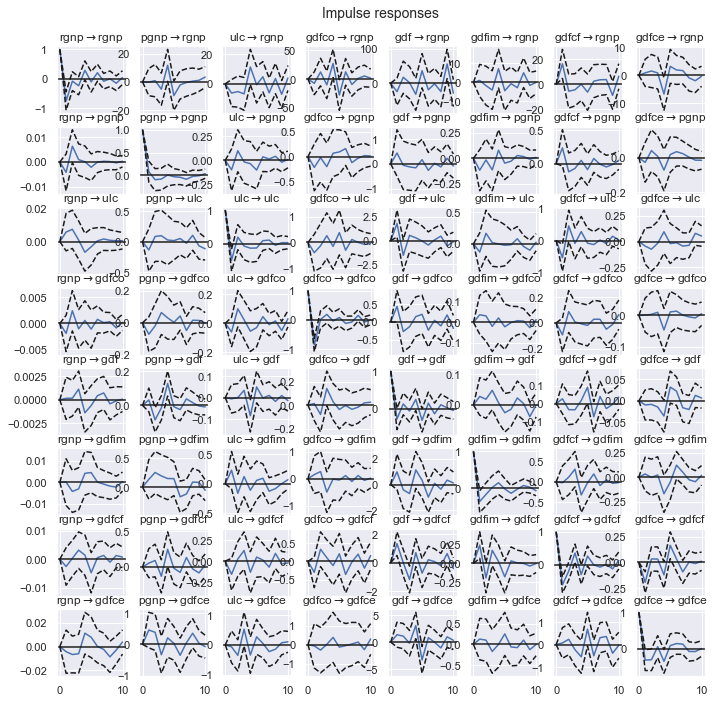

In [18]:
irf = model_fitted.irf(10)
irf.plot(orth=False);

Note the plot function is flexible and can plot only variables of interest if so desired:

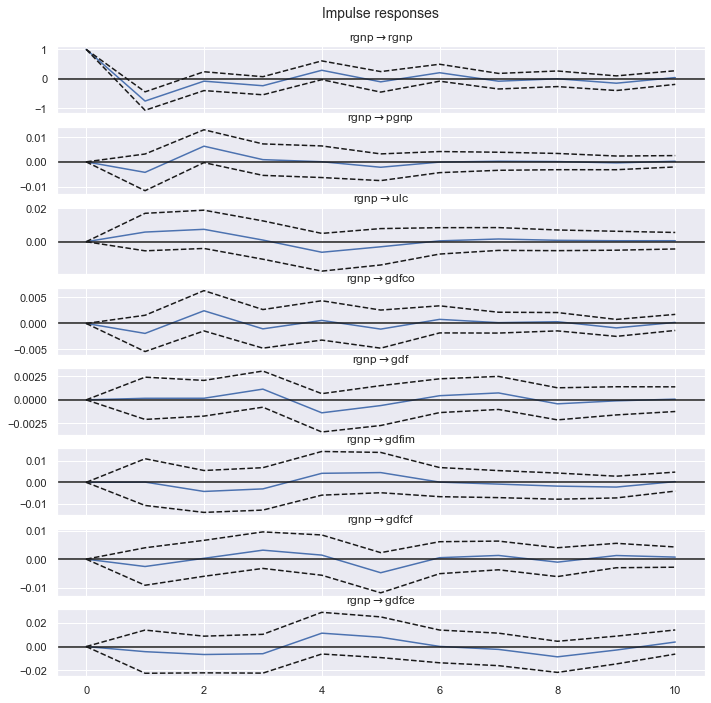

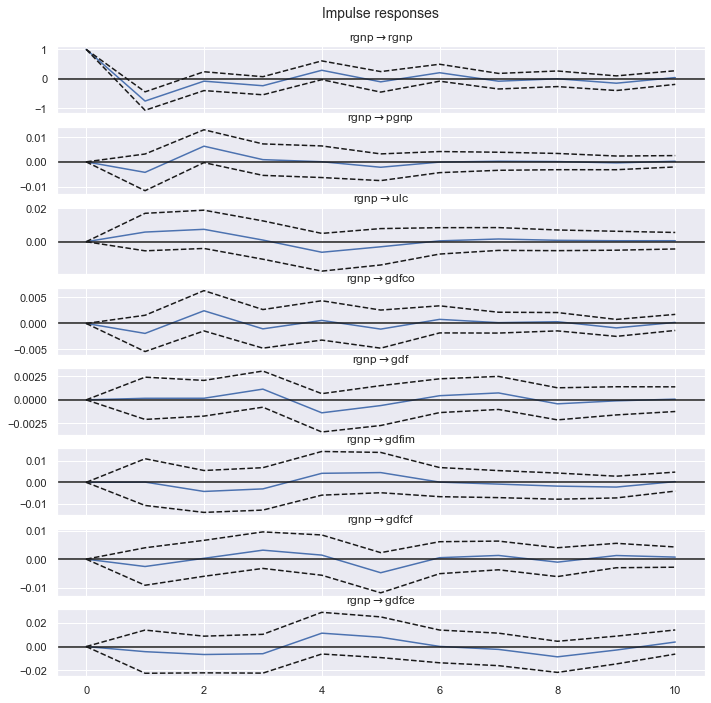

In [19]:
irf.plot(impulse='rgnp')

The cumulative effects can be plotted with the long run effects as follows:

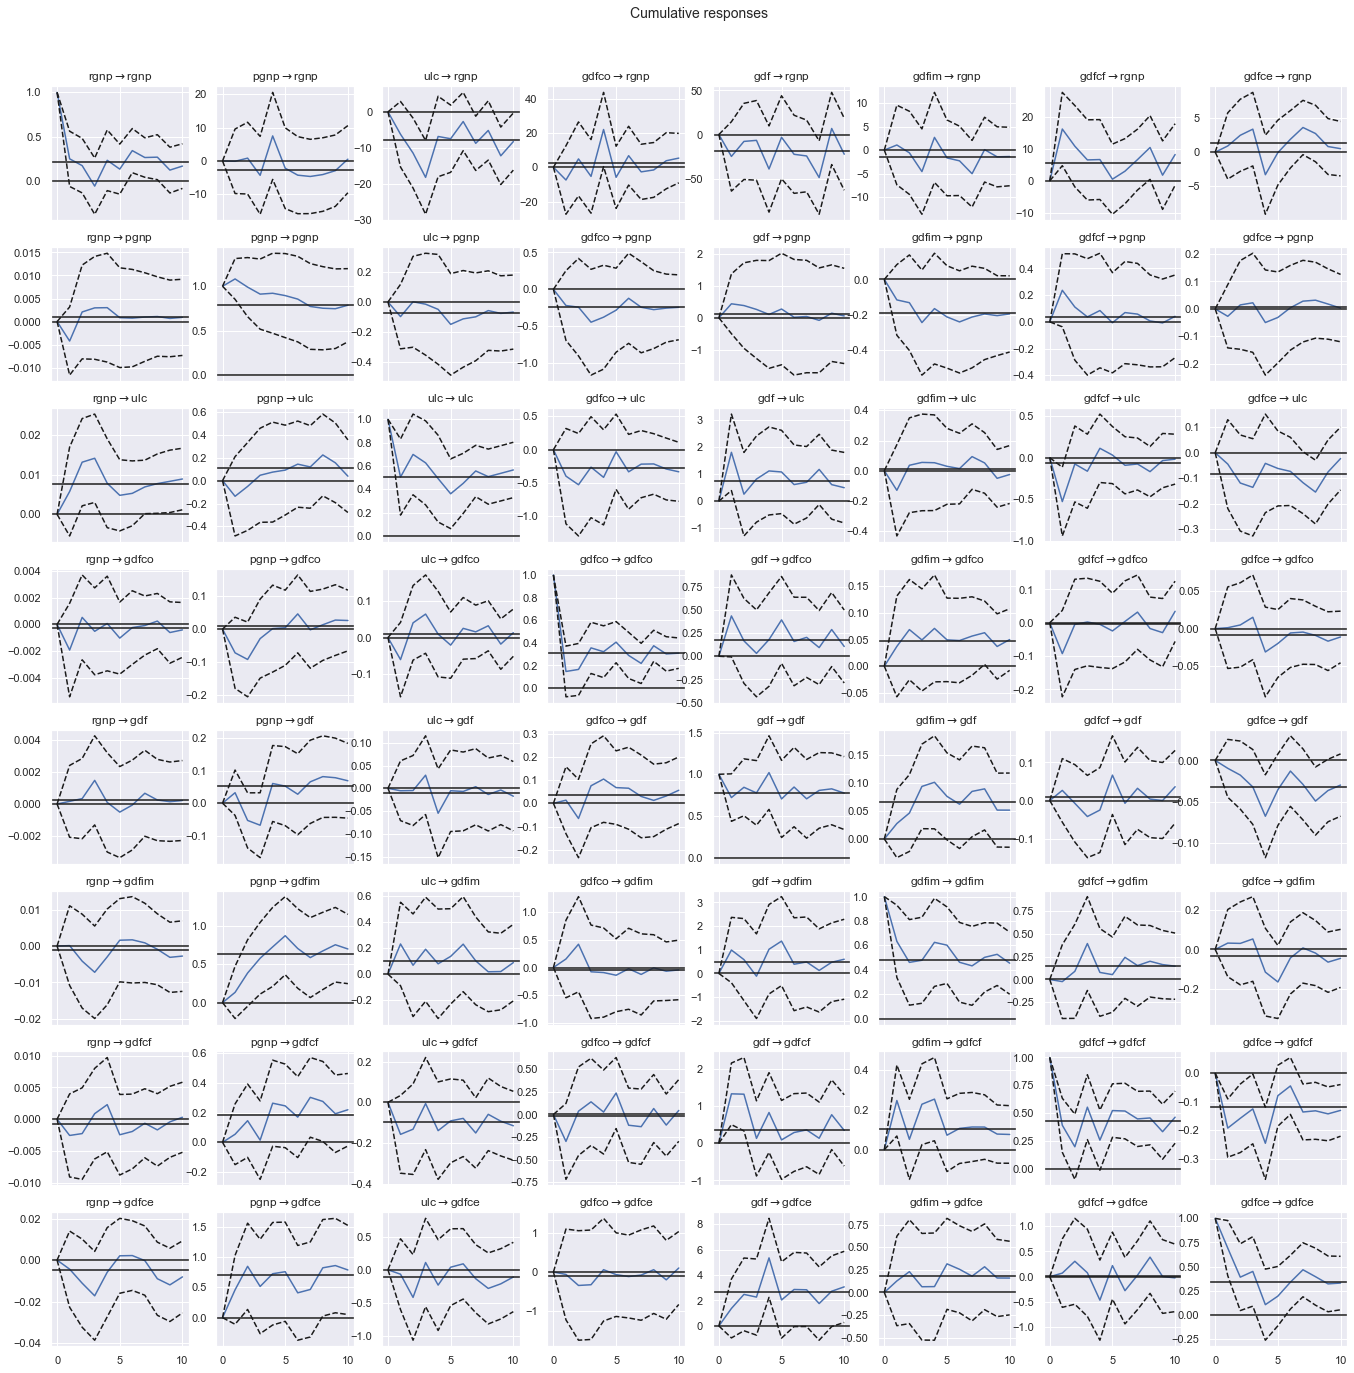

In [20]:
irf.plot_cum_effects(orth=False, figsize=(20, 20));

## Check for Serial Correlation of Residuals using Durbin Watson statistic

Serial correlation of residuals is used to check if there is any leftover pattern in the residuals (errors). If there is any correlation left in the residuals, then, there is some pattern in the time series that is still left to be explained by the model. In that case, the typical course of action is to either increase the order of the model or induce more predictors into the system or look for a different algorithm to model the time series.  

So, checking for serial correlation is to ensure that the model is sufficiently able to explain the variances and patterns in the time series.  

Recall that the value of this statistic can vary between 0 and 4. The closer it is to the value 2, then there is no significant serial correlation. The closer to 0, there is a positive serial correlation, and the closer it is to 4 implies negative serial correlation.

In [21]:
def adjust(val, length= 6): return str(val).ljust(length)

In [22]:
out = durbin_watson(model_fitted.resid)

for col, val in zip(df.columns, out):
    print(adjust(col), ':', round(val, 2))

rgnp   : 2.09
pgnp   : 2.02
ulc    : 2.17
gdfco  : 2.05
gdf    : 2.25
gdfim  : 1.99
gdfcf  : 2.2
gdfce  : 2.17


The serial correlation seems quite alright. Let’s proceed with the forecast.

## Forecast VAR model

In order to forecast, the VAR model expects up to the lag order number of observations from the past data. This is because, the terms in the VAR model are essentially the lags of the various time series in the dataset, so you need to provide it as many of the previous values as indicated by the lag order used by the model.

In [23]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 4

4


In [24]:
# Input data for forecasting
forecast_input = df_differenced.values[-lag_order:]
forecast_input

array([[ 13.5,   0.1,   1.4,   0.1,   0.1,  -0.1,   0.4,  -2. ],
       [-23.6,   0.2,  -2. ,  -0.5,  -0.1,  -0.2,  -0.3,  -1.2],
       [ -3.3,   0.1,   3.1,   0.5,   0.3,   0.4,   0.9,   2.2],
       [ -3.9,   0.2,  -2.1,  -0.4,   0.2,  -1.5,   0.9,  -0.3]])

In [25]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=df.index[-nobs:], columns=df.columns + '_2d')
df_forecast

,rgnp_2d,pgnp_2d,ulc_2d,gdfco_2d,gdf_2d,gdfim_2d,gdfcf_2d,gdfce_2d
date,,,,,,,,
1988-10-01,48.322456,1.250774,0.595993,0.265657,-0.104146,0.304119,-0.917227,-0.113061
1989-01-01,-34.962286,-0.387966,-0.329877,-0.042217,0.164633,1.357223,0.618163,3.029975
1989-04-01,20.392680,0.291298,0.390812,-0.134488,-0.486073,-0.149551,-1.238234,-2.345223
1989-07-01,-37.416599,-0.280943,0.367912,0.102797,0.333371,-0.502103,0.469468,0.517424


The forecasts are generated but it is on the scale of the training data used by the model. So, to bring it back up to its original scale, you need to **de-difference** it as many times you had differenced the original input data. In our case, it is two times.

## Invert the transformation to get the real forecast

In [26]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [27]:
df_results = invert_transformation(df_train, df_forecast, second_diff=True)        
df_results.loc[:, ['rgnp_forecast', 'pgnp_forecast', 'ulc_forecast', 'gdfco_forecast',
                   'gdf_forecast', 'gdfim_forecast', 'gdfcf_forecast', 'gdfce_forecast']]

,rgnp_forecast,pgnp_forecast,ulc_forecast,gdfco_forecast,gdf_forecast,gdfim_forecast,gdfcf_forecast,gdfce_forecast
date,,,,,,,,
1988-10-01,4123.022456,3996.950774,181.095993,132.965657,126.395854,106.604119,125.082773,93.186939
1989-01-01,4168.382626,4021.613582,182.262108,134.389097,128.056341,108.365461,127.283708,96.603854
1989-04-01,4234.135476,4046.567687,183.819036,135.678050,129.230756,109.977252,128.246409,97.675545
1989-07-01,4262.471728,4071.240850,185.743875,137.069799,130.738542,111.086940,129.678579,99.264661


The forecasts are back to the original scale. We can proceed to plotting and comparing forecasts to the actual data.

## Plot of Forecasted vs Actual data

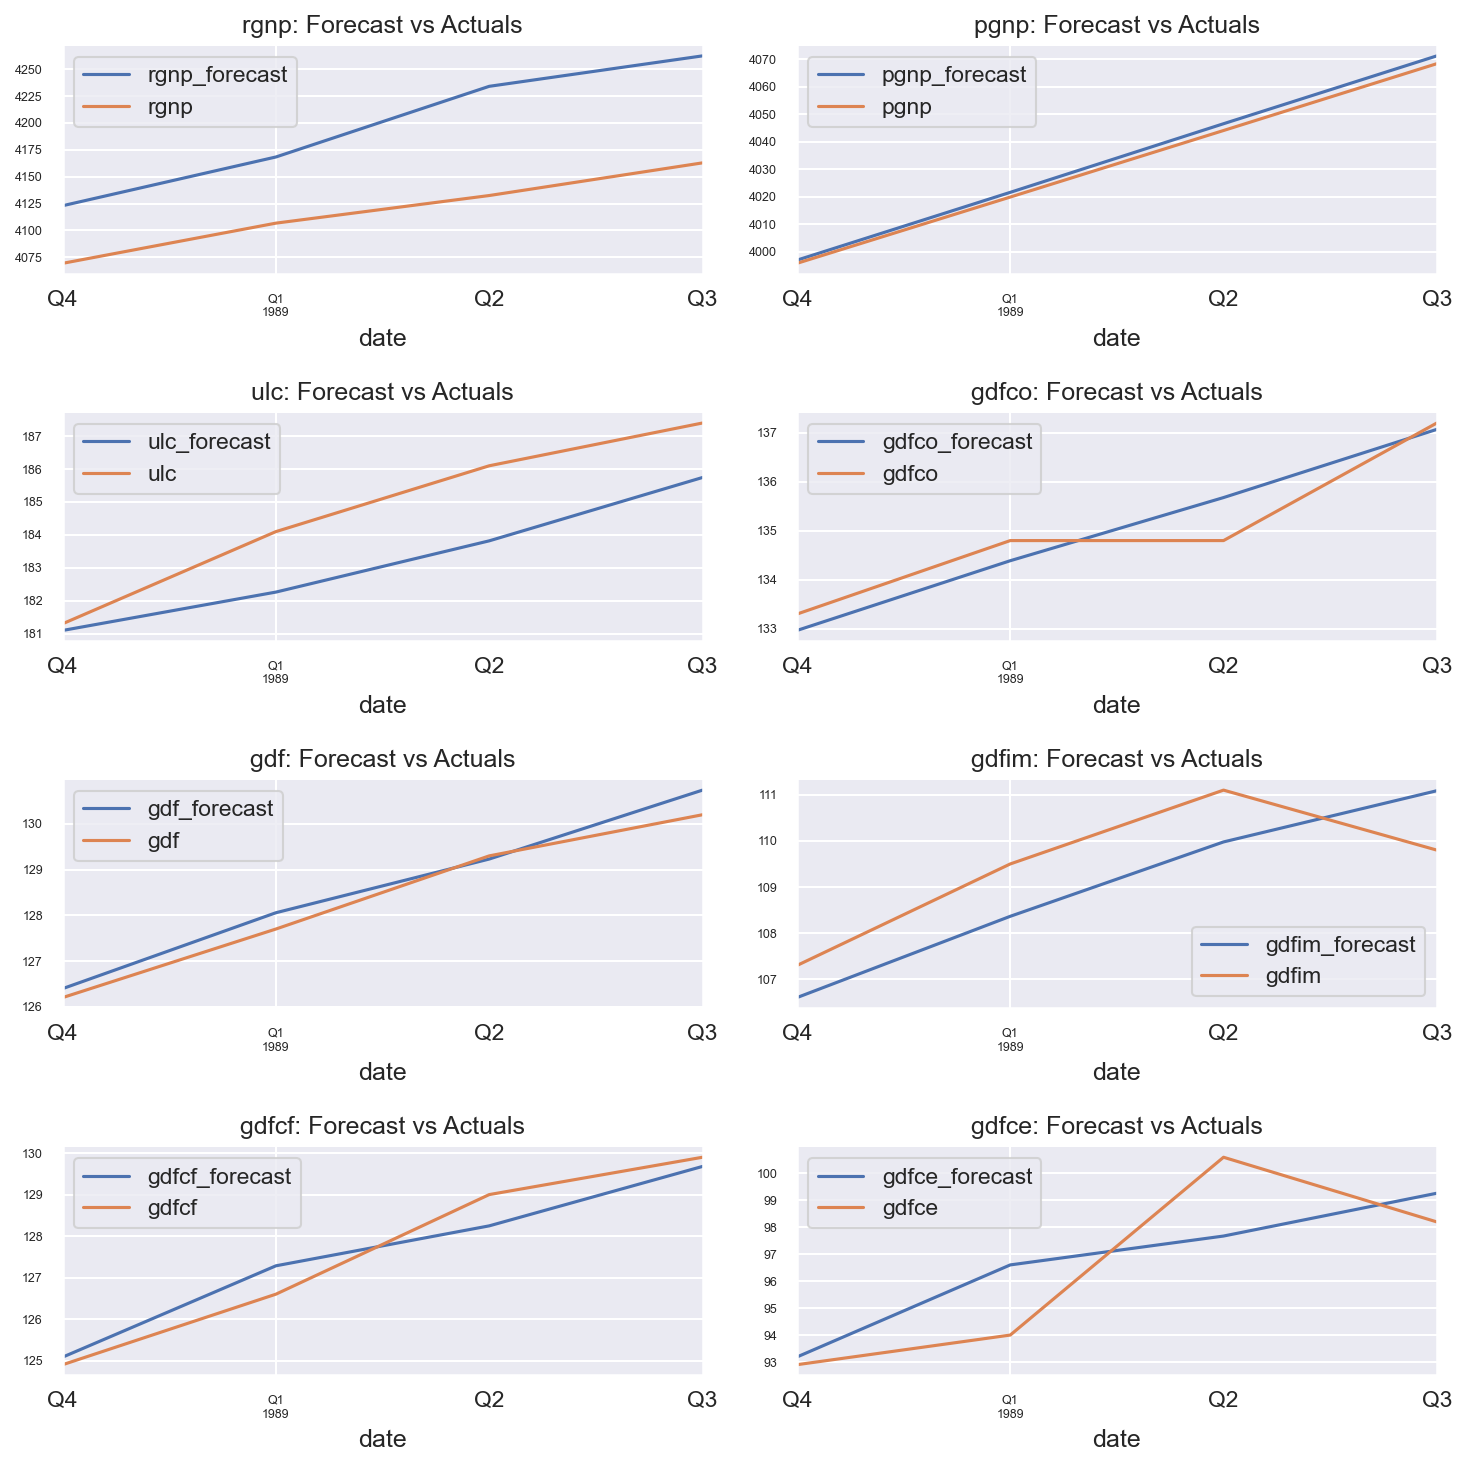

In [28]:
fig, axes = plt.subplots(nrows=int(len(df.columns)/2), ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

## Evaluate the Forecasts

To evaluate the forecasts, you can compute and compare a comprehensive set of metrics, namely, the MAPE, ME, MAE, MPE, RMSE, corr and minmax.

In [29]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})

In [30]:
print('Forecast Accuracy of: rgnp')
accuracy_prod = forecast_accuracy(df_results['rgnp_forecast'].values, df_test['rgnp'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: pgnp')
accuracy_prod = forecast_accuracy(df_results['pgnp_forecast'].values, df_test['pgnp'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: ulc')
accuracy_prod = forecast_accuracy(df_results['ulc_forecast'].values, df_test['ulc'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: gdfco')
accuracy_prod = forecast_accuracy(df_results['gdfco_forecast'].values, df_test['gdfco'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: gdf')
accuracy_prod = forecast_accuracy(df_results['gdf_forecast'].values, df_test['gdf'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: gdfim')
accuracy_prod = forecast_accuracy(df_results['gdfim_forecast'].values, df_test['gdfim'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: gdfcf')
accuracy_prod = forecast_accuracy(df_results['gdfcf_forecast'].values, df_test['gdfcf'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: gdfce')
accuracy_prod = forecast_accuracy(df_results['gdfce_forecast'].values, df_test['gdfce'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

Forecast Accuracy of: rgnp


C:\Users\Vitali\AppData\Local\Temp\ipykernel_980\2363812276.py:9: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)
C:\Users\Vitali\AppData\Local\Temp\ipykernel_980\2363812276.py:11: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)


mape   :  0.0192
me     :  79.1031
mae    :  79.1031
mpe    :  0.0192
rmse   :  82.0245
corr   :  0.9849
minmax :  0.0188

Forecast Accuracy of: pgnp
mape   :  0.0005
me     :  2.0432
mae    :  2.0432
mpe    :  0.0005
rmse   :  2.146
corr   :  1.0
minmax :  0.0005

Forecast Accuracy of: ulc
mape   :  0.0081
me     :  -1.4947
mae    :  1.4947
mpe    :  -0.0081
rmse   :  1.6856
corr   :  0.963
minmax :  0.0081

Forecast Accuracy of: gdfco
mape   :  0.0033
me     :  0.0007
mae    :  0.4384
mpe    :  0.0
rmse   :  0.5169
corr   :  0.9407
minmax :  0.0032

Forecast Accuracy of: gdf
mape   :  0.0023
me     :  0.2554
mae    :  0.29
mpe    :  0.002
rmse   :  0.3392
corr   :  0.9905
minmax :  0.0022

Forecast Accuracy of: gdfim
mape   :  0.0097
me     :  -0.4166
mae    :  1.06
mpe    :  -0.0038
rmse   :  1.0826
corr   :  0.807
minmax :  0.0096

Forecast Accuracy of: gdfcf
mape   :  0.0036
me     :  -0.0271
mae    :  0.4604
mpe    :  -0.0002
rmse   :  0.5286
corr   :  0.9713
minmax :  0.0036

Fo

In this lecture we covered VAR from scratch beginning from:
1. the intuition behind it, 
2. interpreting the formula, 
3. causality tests, 
4. finding the optimal order of the VAR model, 
5. preparing the data for forecasting, 
6. build the model, 
7. checking for serial autocorrelation, 
8. inverting the transform to get the actual forecasts, 
9. plotting the results and
10. computing the accuracy metrics. 

# Further Readings
- VAR in Python: https://www.statsmodels.org/dev/vector_ar.html
- https://www.statsmodels.org/dev/generated/statsmodels.tsa.vector_ar.var_model.VAR.fit.html#statsmodels.tsa.vector_ar.var_model.VAR.fit
- https://www.statsmodels.org/dev/generated/statsmodels.tsa.vector_ar.var_model.VAR.select_order.html?highlight=select_order#statsmodels.tsa.vector_ar.var_model.VAR.select_order


# <font color=red> Homework: </font> 
Try to follow the VAR analysis steps above for the US Macro data contained in `us_macro_quarterly.cvs`. 
To help you get started, the data can be loaded as follows:

In [3]:
df=pd.read_csv('data/us_macro_quarterly.csv')
df

,Date,GDPC96,JAPAN_IP,PCECTPI,GS10,GS1,TB3MS,UNRATE,EXUSUK,CPIAUCSL
0,1957:01,2851.778,8.414363,16.449,3.403333,3.390000,3.096667,3.933333,NaN,27.776667
1,1957:02,2845.453,9.097347,16.553,3.626667,3.540000,3.140000,4.100000,NaN,28.013333
2,1957:03,2873.169,9.042708,16.687,3.926667,3.963333,3.353333,4.233333,NaN,28.263333
3,1957:04,2843.718,8.796834,16.773,3.633333,3.586667,3.310000,4.933333,NaN,28.400000
4,1958:01,2770.000,8.632918,16.978,3.040000,2.160000,1.756667,6.300000,NaN,28.736667
...,...,...,...,...,...,...,...,...,...,...
223,2012:04,15539.628,94.258812,106.622,1.706667,0.173333,0.086667,7.833333,1.606433,231.277000
224,2013:01,15583.948,94.725440,106.909,1.950000,0.153333,0.086667,7.700000,1.550633,232.102667
225,2013:02,15679.677,95.992001,106.878,1.996667,0.126667,0.050000,7.500000,1.536700,232.086667
226,2013:03,15839.347,97.558537,107.387,2.710000,0.123333,0.033333,7.233333,1.552300,233.597000


In [10]:
formatted_dates=pd.to_datetime(df['Date'], format='%Y:%m', errors='coerce')
formatted_dates

0     1957-01-01
1     1957-02-01
2     1957-03-01
3     1957-04-01
4     1958-01-01
         ...    
223   2012-04-01
224   2013-01-01
225   2013-02-01
226   2013-03-01
227   2013-04-01
Name: Date, Length: 228, dtype: datetime64[ns]

In [11]:
# Check if is okay: sum should be zero
sum(formatted_dates.isnull())

0

In [12]:
# assign dates to index and drop the redundant column
df.index=formatted_dates
df.drop(columns=['Date'],inplace=True)
df

,GDPC96,JAPAN_IP,PCECTPI,GS10,GS1,TB3MS,UNRATE,EXUSUK,CPIAUCSL
Date,,,,,,,,,
1957-01-01,2851.778,8.414363,16.449,3.403333,3.390000,3.096667,3.933333,NaN,27.776667
1957-02-01,2845.453,9.097347,16.553,3.626667,3.540000,3.140000,4.100000,NaN,28.013333
1957-03-01,2873.169,9.042708,16.687,3.926667,3.963333,3.353333,4.233333,NaN,28.263333
1957-04-01,2843.718,8.796834,16.773,3.633333,3.586667,3.310000,4.933333,NaN,28.400000
1958-01-01,2770.000,8.632918,16.978,3.040000,2.160000,1.756667,6.300000,NaN,28.736667
...,...,...,...,...,...,...,...,...,...
2012-04-01,15539.628,94.258812,106.622,1.706667,0.173333,0.086667,7.833333,1.606433,231.277000
2013-01-01,15583.948,94.725440,106.909,1.950000,0.153333,0.086667,7.700000,1.550633,232.102667
2013-02-01,15679.677,95.992001,106.878,1.996667,0.126667,0.050000,7.500000,1.536700,232.086667
